# Attention tokens

While exploring some other behaviour I noticed that different heads consistently produce tokens from a compacted subsets of the full vocabulary set when you project the components of a head onto the residual stream without going through the MLP layers. I think this is likely heavily influenced by positional encodings.

Each head appears to use it's learn vocabulary subset (the attention tokens) to chunk inputs in ways specific to that head. Some heads compress inputs into a small number attention tokens - as few as 3-4 for 16 token inputs. Others expand and others linearly track or double with input. My intuition is that this represents how heads structurally decompose inputs to represent meaning for their specific tasks and so provides a means for classifying heads.

I also look at the macro patterns that emerge across all the heads in the model and find some striking results. For example, the t-SNE plot below shows how the embeddings of the attention tokens are distributed. The plot on the right shows how the attention tokens are shared between heads. Both are quite remarkable - to the degree that I worry this is either an embarassing bug or a trivial artefact of positional encodings.

TODO add plot image

In [1]:
import torch
from transformer_lens import HookedTransformer 
import plotly.io as pio
import matplotlib.pyplot as plt

from utils import *

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


In [9]:
pio.renderers.default = "png"
plt.ioff()

The plot below allows you to explore how attention tokens are generated. Note, the colourscale is based on the order in which the attention tokens are discovered during generation meaning brighter colours represent tokens generated later in the process. This means that colours don't represent absolute token values and instead more of a relative position within the generation.

In [3]:
cache = run_prompts(
    model, 
    "The next sentence is false. The previous sentence is true.",
)

In [13]:
attn_data = calculate_attns(cache, 0, 1)
plot = plot_attn(cache, attn_data, feature_index=0)

figure(plot, title="Attention token plot for heads in the first layer",
       footer='The heads in the first layer for the prompt "The next sentence is false. The previous sentence is true."')

In [11]:
plot, axs = plt.subplots(3, 4, figsize=(16, 5))
plt.subplots_adjust(wspace=0, hspace=0.5)
for i in range(12):
    attn_data = calculate_attns(cache, 0, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

figure(plot, title="Attention token plot for heads in the first layer",
    description='The heads in the first layer for the prompt "The next sentence is false. The previous sentence is true."')

To get a sense of how attention tokens are generated I want to test over a reasonably large and varied inputs. For the time being I'm using the imdb dataset because it contains a wide variety of natural language from multiple authors and is relatively small.

The code below extracts 3 random prompts from the dataset and uses them as the input into the model. We then use the cached activations to generate a dataset of attention tokens for each component across each head. The length of each prompt is capped at 16 tokens.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")
inputs = random.choices(dataset["train"]["text"], k=3)
inputs = model.to_string(model.to_tokens(inputs)[:, :16])
cache = run_prompts(model, *inputs)

data = generate(cache)
df = to_df(data)
df.to_csv("imdb_example.csv", index=False)
df

Generating the attention token dataset from activations can take a while depending on how many inputs you have and how long they are. To save time, I've pre-generated a dataset of 32 prompts with a token length of 32.

In [66]:
df = load('../data/32x32-random_attn.csv')
df

,layer,head,Input token,attn,hp,q,k,v
0,0.0,0.0,50256.0,1.000000e+00,357.0,11.0,11.0,262.0
1,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...
5018107,11.0,11.0,35572.0,2.509927e-07,47992.0,16100.0,21451.0,43617.0
5018108,11.0,11.0,35572.0,2.043300e-07,47992.0,16100.0,21451.0,43617.0
5018109,11.0,11.0,35572.0,1.654549e-07,47992.0,16100.0,21451.0,43617.0
5018110,11.0,11.0,35572.0,1.388652e-07,47992.0,16100.0,21451.0,43617.0


We can plot each of these to get a sense of how the attention tokens are used differently for each head.

In [ ]:
# TODO add gallery of all 32x32 imdb token plots

While it's interesting to look at the patterns that emerge in the token plots, and I think it can be useful for interpreting head behaviour (see below), it doesn't help to understand any macro patterns that may exist across the model heads.



In [67]:
token_counts = token_freq_data(model, df, 4, (144, 32, 32, 32))
token_counts

,Head,Token,Frequency,Token str,SortedIndex
0,0,11,390,",",2.0
1,0,198,30,\n,8.0
2,0,290,30,and,8.0
3,0,357,62,(,5.0
4,0,439,60,all,6.0
...,...,...,...,...,...
1108,152,30044,1045,Jude,2.0
1109,152,47992,14399,cit,1.0
1110,153,9228,8,burgh,3.0
1111,153,23712,155,eday,2.0


In [74]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), )
plot_token_frequencies(model, token_counts, colorbar_label='Head', ax=axs[0])
plot_unique_tokens_by_head(model, token_counts, s=25, colorbar_label='Layer', ax=axs[1])
plot_unique_tokens_by_layer_head(model, token_counts, s=50, colorbar_label='Layer', ax=axs[2])

figure(fig, title="Token frequencies", description="Token frequencies by layer and head", footer="The next sentence is false. The previous sentence is true.")

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
plot_token_embeddings(model, token_counts, 'PCA', ax=axs[0])
plot_token_embeddings(model, token_counts, 'UMAP', ax=axs[1])

figure(
    fig, 
    title="Token embeddings", 
    description="Token embeddings by layer and head", 
    footer="The next sentence is false. The previous sentence is true.",
)

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


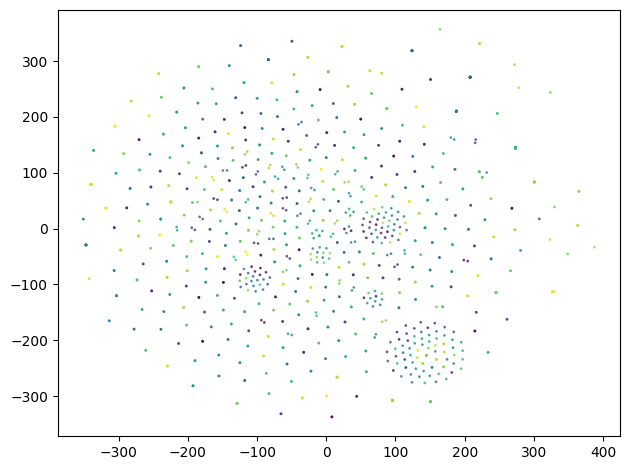

In [69]:
plot_token_embeddings(model, token_counts, 'TSNE', s=1)

# TODO

In [70]:
at = df[['layer', 'head', 'Input token', 'hp', 'attn']]
at.columns = ['layer', 'head', 'input_token', 'attention_token', 'attention_score']
print(at)

layer  head  input_token  attention_token  attention_score
0          0.0   0.0      50256.0            357.0     1.000000e+00
1         -1.0  -1.0         -1.0             -1.0    -1.000000e+00
2         -1.0  -1.0         -1.0             -1.0    -1.000000e+00
3         -1.0  -1.0         -1.0             -1.0    -1.000000e+00
4         -1.0  -1.0         -1.0             -1.0    -1.000000e+00
...        ...   ...          ...              ...              ...
5018107   11.0  11.0      35572.0          47992.0     2.509927e-07
5018108   11.0  11.0      35572.0          47992.0     2.043300e-07
5018109   11.0  11.0      35572.0          47992.0     1.654549e-07
5018110   11.0  11.0      35572.0          47992.0     1.388652e-07
5018111   11.0  11.0      35572.0          47992.0     1.163348e-07

[5018112 rows x 5 columns]

In [71]:
import pandas as pd

# Assuming at is your DataFrame containing the data, including the 'layer' and 'head' columns

# Analyze subgroups for each attention head
subgroup_data = []
for layer, head in at[['layer', 'head']].drop_duplicates().itertuples(index=False):
    subgroup_mask = (at['layer'] == layer) & (at['head'] == head)
    unique_tokens = at.loc[subgroup_mask, 'attention_token'].unique()
    subgroup_data.append({
        'Layer': layer,
        'Head': head,
        'Unique Tokens': len(unique_tokens),
        'Tokens': ','.join(map(str, unique_tokens))
    })

subgroups_df = pd.DataFrame(subgroup_data)

# Analyze shared tokens between subgroups
shared_token_data = []
for i, (layer1, head1) in enumerate(subgroups_df[['Layer', 'Head']].itertuples(index=False)):
    for layer2, head2 in subgroups_df[['Layer', 'Head']].iloc[i+1:].itertuples(index=False):
        tokens1 = set(map(float, subgroups_df[(subgroups_df['Layer'] == layer1) & (subgroups_df['Head'] == head1)]['Tokens'].iloc[0].split(',')))
        tokens2 = set(map(float, subgroups_df[(subgroups_df['Layer'] == layer2) & (subgroups_df['Head'] == head2)]['Tokens'].iloc[0].split(',')))
        shared_tokens = tokens1.intersection(tokens2)
        if len(shared_tokens) > 0:
            shared_token_data.append({
                'Subgroup 1': f"G_({layer1}, {head1})",
                'Subgroup 2': f"G_({layer2}, {head2})",
                'Shared Tokens': len(shared_tokens),
                'Tokens': ','.join(map(str, shared_tokens))
            })

shared_tokens_df = pd.DataFrame(shared_token_data)

In [78]:
model.to_string(198)

'\n'

In [80]:
shared_tokens_df.sort_values('Shared Tokens', ascending=False)

,Subgroup 1,Subgroup 2,Shared Tokens,Tokens
2611,"G_(10.0, 8.0)","G_(10.0, 10.0)",4,"37600.0,290.0,11.0,262.0"
1337,"G_(3.0, 5.0)","G_(10.0, 7.0)",3,"705.0,11.0,262.0"
2489,"G_(8.0, 6.0)","G_(9.0, 1.0)",3,"1576.0,11.0,262.0"
109,"G_(0.0, 3.0)","G_(4.0, 7.0)",3,"257.0,290.0,11.0"
1302,"G_(3.0, 5.0)","G_(5.0, 4.0)",3,"290.0,11.0,262.0"
...,...,...,...,...
980,"G_(2.0, 3.0)","G_(2.0, 4.0)",1,11.0
979,"G_(2.0, 1.0)","G_(11.0, 10.0)",1,11.0
978,"G_(2.0, 1.0)","G_(11.0, 5.0)",1,11.0
977,"G_(2.0, 1.0)","G_(11.0, 4.0)",1,11.0


In [97]:
index_order = [f"G_({layer}, {head})" for layer in range(12) for head in range(12)]
p = shared_tokens_df.pivot(index='Subgroup 1', columns='Subgroup 2', values='Shared Tokens')
p = p.reindex(index=index_order, columns=index_order)
p

Subgroup 2,"G_(0, 0)","G_(0, 1)","G_(0, 2)","G_(0, 3)","G_(0, 4)","G_(0, 5)","G_(0, 6)","G_(0, 7)","G_(0, 8)","G_(0, 9)","G_(0, 10)","G_(0, 11)","G_(1, 0)","G_(1, 1)","G_(1, 2)","G_(1, 3)","G_(1, 4)","G_(1, 5)","G_(1, 6)","G_(1, 7)","G_(1, 8)","G_(1, 9)","G_(1, 10)","G_(1, 11)","G_(2, 0)","G_(2, 1)","G_(2, 2)","G_(2, 3)","G_(2, 4)","G_(2, 5)","G_(2, 6)","G_(2, 7)","G_(2, 8)","G_(2, 9)","G_(2, 10)","G_(2, 11)","G_(3, 0)","G_(3, 1)","G_(3, 2)","G_(3, 3)","G_(3, 4)","G_(3, 5)","G_(3, 6)","G_(3, 7)","G_(3, 8)","G_(3, 9)","G_(3, 10)","G_(3, 11)","G_(4, 0)","G_(4, 1)","G_(4, 2)","G_(4, 3)","G_(4, 4)","G_(4, 5)","G_(4, 6)","G_(4, 7)","G_(4, 8)","G_(4, 9)","G_(4, 10)","G_(4, 11)","G_(5, 0)","G_(5, 1)","G_(5, 2)","G_(5, 3)","G_(5, 4)","G_(5, 5)","G_(5, 6)","G_(5, 7)","G_(5, 8)","G_(5, 9)","G_(5, 10)","G_(5, 11)","G_(6, 0)","G_(6, 1)","G_(6, 2)","G_(6, 3)","G_(6, 4)","G_(6, 5)","G_(6, 6)","G_(6, 7)","G_(6, 8)","G_(6, 9)","G_(6, 10)","G_(6, 11)","G_(7, 0)","G_(7, 1)","G_(7, 2)","G_(7, 3)","G_(7, 4)","G_(7, 5)","G_(7, 6)","G_(7, 7)","G_(7, 8)","G_(7, 9)","G_(7, 10)","G_(7, 11)","G_(8, 0)","G_(8, 1)","G_(8, 2)","G_(8, 3)","G_(8, 4)","G_(8, 5)","G_(8, 6)","G_(8, 7)","G_(8, 8)","G_(8, 9)","G_(8, 10)","G_(8, 11)","G_(9, 0)","G_(9, 1)","G_(9, 2)","G_(9, 3)","G_(9, 4)","G_(9, 5)","G_(9, 6)","G_(9, 7)","G_(9, 8)","G_(9, 9)","G_(9, 10)","G_(9, 11)","G_(10, 0)","G_(10, 1)","G_(10, 2)","G_(10, 3)","G_(10, 4)","G_(10, 5)","G_(10, 6)","G_(10, 7)","G_(10, 8)","G_(10, 9)","G_(10, 10)","G_(10, 11)","G_(11, 0)","G_(11, 1)","G_(11, 2)","G_(11, 3)","G_(11, 4)","G_(11, 5)","G_(11, 6)","G_(11, 7)","G_(11, 8)","G_(11, 9)","G_(11, 10)","G_(11, 11)"
Subgroup 1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"G_(0, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"G_(0, 1)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"G_(0, 2)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"G_(0, 3)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create custom tick labels and ordered index
num_layers = 12  # Specify the number of layers
num_heads = 12   # Specify the number of heads

tick_labels = [f"G_({layer}, {head})" for layer in range(num_layers) for head in range(num_heads)]

# Create a MultiIndex for the desired order
multi_index = pd.MultiIndex.from_product([range(num_layers), range(num_heads)], names=['Layer', 'Head'])
ordered_index = pd.Index([f"G_({layer}, {head})" for layer, head in multi_index], name='Subgroup')

# Set the index and columns of the shared_tokens_df DataFrame to the ordered_index
shared_tokens_df['Subgroup 1'] = shared_tokens_df['Subgroup 1'].map(lambda x: tuple(map(float, x.strip('G_()').split(', '))))
shared_tokens_df['Subgroup 2'] = shared_tokens_df['Subgroup 2'].map(lambda x: tuple(map(float, x.strip('G_()').split(', '))))
shared_tokens_df = shared_tokens_df.set_index(['Subgroup 1', 'Subgroup 2']).reindex(multi_index, level=[0, 1]).reset_index()

# Create a pivot table from the shared_tokens_df DataFrame
pivot_df = shared_tokens_df.pivot(index='Subgroup 1', columns='Subgroup 2', values='Shared Tokens')

# Fill NaN values with 0
pivot_df.fillna(0, inplace=True)

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_df, annot=False, cmap='viridis', fmt='d', cbar_kws={'label': 'Number of Shared Tokens'})
plt.title('Shared Token Overlaps between Subgroups')

# Set custom tick labels for x-axis and y-axis
plt.xticks(range(len(tick_labels)), tick_labels, rotation=90)
plt.yticks(range(len(tick_labels)), tick_labels, rotation=0)  # Added rotation=0 for y-axis labels

plt.tight_layout()
plt.show()

ValueError: invalid literal for int() with base 10: '0.0'

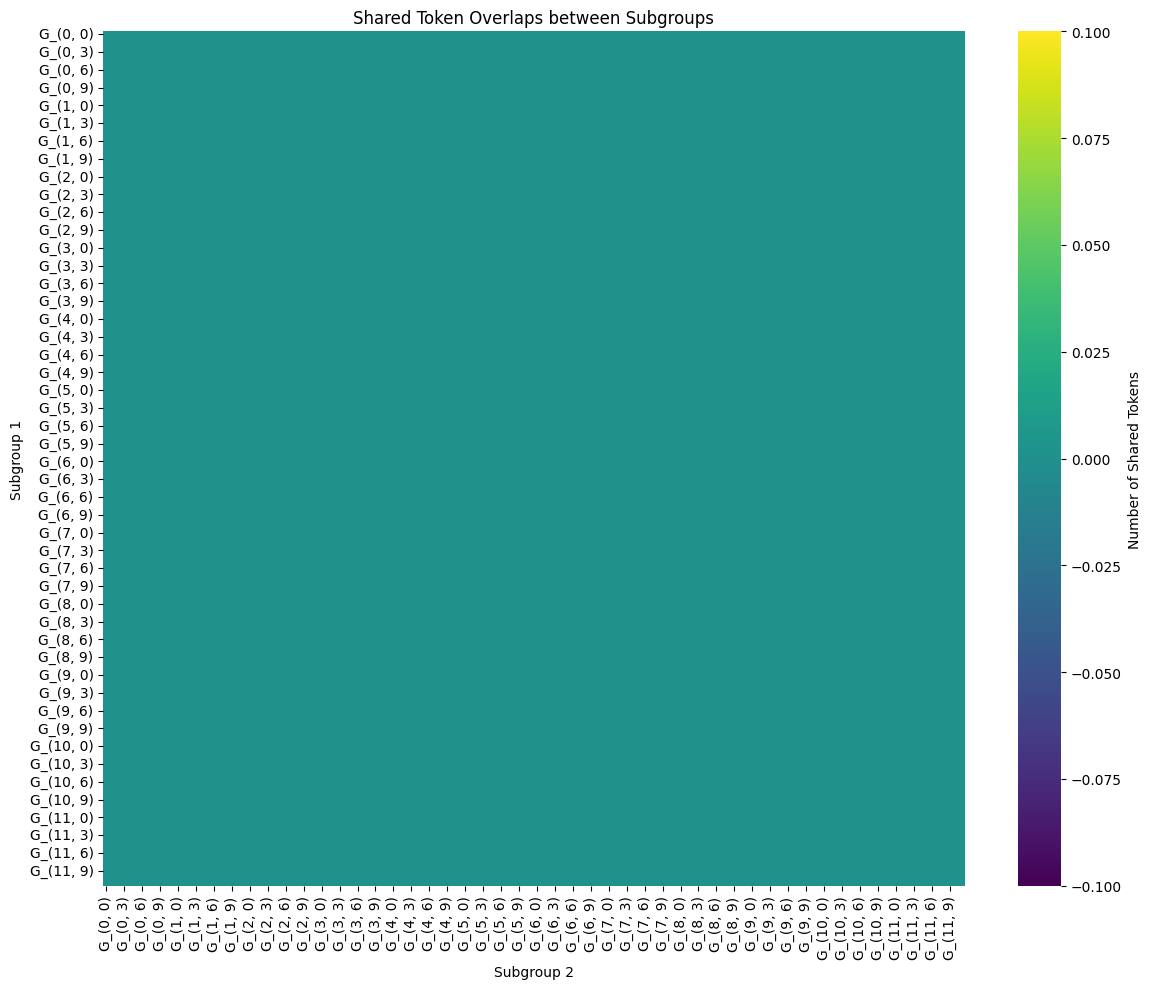

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create custom tick labels and ordered index
num_layers = 12  # Specify the number of layers
num_heads = 12   # Specify the number of heads

tick_labels = [f"G_({layer}, {head})" for layer in range(num_layers) for head in range(num_heads)]

# Create a pivot table from the shared_tokens_df DataFrame
pivot_df = shared_tokens_df.pivot(index='Subgroup 1', columns='Subgroup 2', values='Shared Tokens')

# Reindex the pivot table with the desired order
pivot_df = pivot_df.reindex(index=tick_labels, columns=tick_labels)

# Fill NaN values with 0
pivot_df.fillna(0, inplace=True)

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_df, annot=False, cmap='viridis', fmt='d', cbar_kws={'label': 'Number of Shared Tokens'})
plt.title('Shared Token Overlaps between Subgroups')

# Set custom tick labels for x-axis and y-axis

plt.tight_layout()
plt.show()

## Random inputs

Testing with random token inputs provides some insights into how the heads behave in a "default" state. It also makes it easy to change the input length without worrying about being distracted by how that affects the semantic/grammatical structure of the input.

Here are the heads of the first layer using a single random token repeated 62 times.

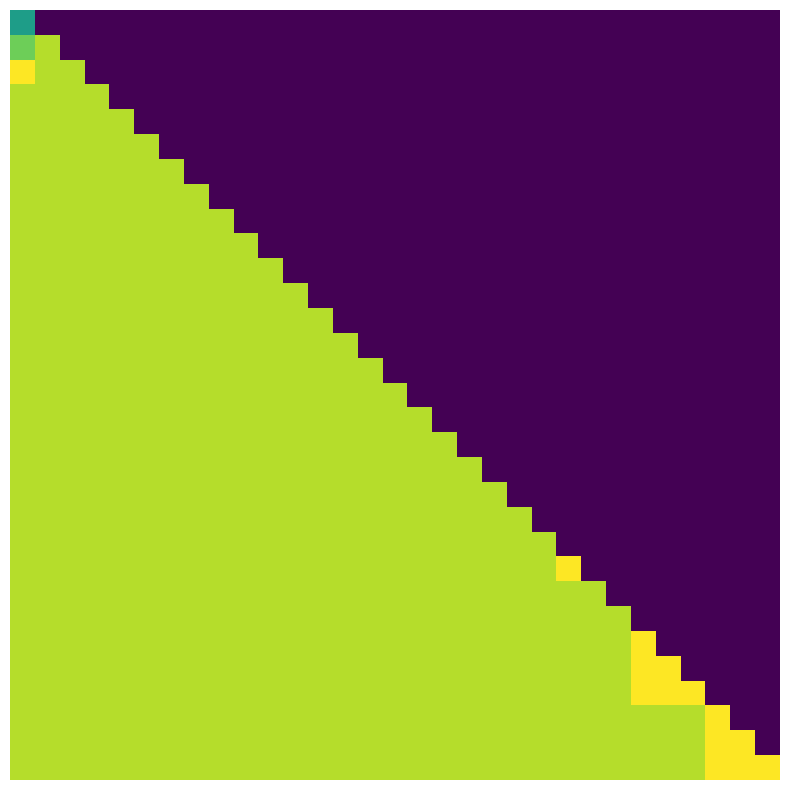

In [63]:
prompt = torch.randint(0, 50257, (1, 3)).repeat(1, 10)
cache = run_prompts(model, *model.to_string(prompt))

attn_data = calculate_attns(cache, 2, 10)
plot_attn(cache, attn_data, hide_labels=True)

In [36]:
token = random.randint(0, 50257)
prompt = torch.full((1, 62), token)
prompt = torch.randint(0, 50257, (1, 3)).repeat(1, 21)
cache = run_prompts(model, *model.to_string(prompt))

plot, axs = plt.subplots(3, 4, figsize=(16, 5))
plt.subplots_adjust(wspace=0, hspace=0.5)
for i in range(12):
    attn_data = calculate_attns(cache, 2, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

figure(plot, title="Random single token")

In [ ]:
prompt = torch.randint(0, 50257, (1, 62))
cache = run_prompts(model, *model.to_string(prompt))
plots = plot_attns(cache, range(12), hide_labels=True)

plot_grid(*plots, title="Attention tokens", description=f'Input: "{cache.prompts[0][:99]}..."')

In [ ]:
prompt = torch.randint(0, 50257, (1, 3)).repeat(1, 21)
cache = run_prompts(model, *model.to_string(prompt))
plots = plot_attns(cache, range(12), show_grid_labels=False, show_axis=False, show_attn_overlay=False)

plot_grid(*plots, title="Attention tokens", description=f'Input: "{cache.prompts[0][:128]}"')

### A note in input length

Input length is important. Up to 31 tokens the attention tokens form surprisingly compact representations of the input across each position. At 32 input tokens some kind of criticality is reached, which dramatically increases the number of attention tokens defined for each input token. You can see this below where the final two lines account for the majority of assigned tokens. It's important to note this doesn't change the existing patterns above, but just makes it much more difficult to view them clearly using this visualization technique.

After 32 tokens, things get a bit weird. The attention token structure doesn't remain in the more complex high token count state - instead it appears to alternate between the simple and complex patterns. However, this somewhat depends on the selected random token so it's difficult to highlight a precise sequence.

Below is the same head (0.0) plotted using input from 31 up to 48 tokens. You can see the simple and complex pattern evolve twice in this range.

The same behaviour occurs with natural language input, but the threshold is less predictable. The point of criticality appears to align with the start of the most recent "block" of text. E.g. if it's a repeating sequence of length 4 the threshold is ~28. This isn't precise, but is relisably closer than 32 as seen with repeated and fully random inputs.

## Specific head analysis

Random repeating sequences provides the clearest interpretability without being devoid of structure so I'm starting there. Understanding how heads evolve based on changing predictable sequences is likely to provide more general insights, but it's worth noting again the risk of these toy inputs not translating to more realistic language.

To provide some structure to the work I plan to evaluate the patterns using this approach:
- Take an input sequence (S) and convert it into a sequence of attention tokens (A)
- Given the next token (t) generate a new sequence of attention tokens using S + t
- Analyse the invariances and symmetries implied by how different sequences produce different attention tokens

### 0.0